In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import spacy
from spacy import displacy
from wordcloud import WordCloud, get_single_color_func
from utils import punct, my_sentencizer, string

In [2]:
nlp = spacy.load('output/model-best')

In [3]:
studio_albums = {
    "Iron Maiden",
    "Killers",
    "The Number Of The Beast",
    "Piece Of Mind",
    "Powerslave",
    "Somewhere In Time",
    "Seventh Son Of A Seventh Son",
    "No Prayer For The Dying",
    "Fear Of The Dark",
    "The X-Factor",
    "Virtual XI",
    "Brave New World",
    "Dance Of Death",
    "A Matter Of Life And Death",
    "The Final Frontier",
    "The Book Of Souls",
    "Senjutsu",
}

In [4]:
iron = pd.read_csv('iron_maiden_songs.tsv', delimiter='\t')
iron = iron[(iron.lyrics.apply(type) == str) & iron.album.isin(studio_albums)]
# there are four pure-instrumental songs, so there's no lyrics listed
# it wasn't a web-scraping error!

In [5]:
print(len(iron), len(set(iron.album)))

158 17


In [6]:
maiden_lyrics_lower = '\n'.join([' '.join([tok.lower() for tok in song.split()]) for song in iron.lyrics]) \
                      .replace('.', '').replace('\\n', ' ')

In [7]:
with open('maiden_all_lyrics.txt', 'w', encoding='utf-8') as f:
    f.write(maiden_lyrics_lower)

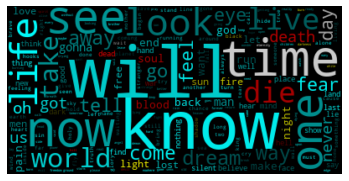

In [8]:
with open('light_words.txt') as f:
    light_words = f.read().split() + ['light']
    
with open('death_words.txt') as f:
    death_words = f.read().split() + ['die', 'grave']
    
with open('time_words.txt') as f:
    time_words = f.read().split() + ['second']
    
with open("stopwords_en.txt", 'w', encoding='utf-8') as f:
    for word in sorted(nlp.Defaults.stop_words):
        f.write(word + '\n')

# everything but the word lists copied almost verbatim from https://amueller.github.io/word_cloud/auto_examples/colored_by_group.html#sphx-glr-auto-examples-colored-by-group-py
class GroupedColorFunc:
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)


wc = WordCloud(collocations=False).generate(maiden_lyrics_lower)
# by default, bigrams and single words are shown. If collocations = False, only single words are shown 

color_to_words = {
    # death words will be colored with a red single color function
    'red': death_words,
    # light words
    'yellow': light_words,
    # time words
    'grey': time_words,
}

default_color = 'cyan'

# Create a color function with multiple tones
grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wc.recolor(color_func=grouped_color_func)

# Plot
# plt.figure(figsize=(40,80))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.savefig('iron_maiden_wordcloud.png')

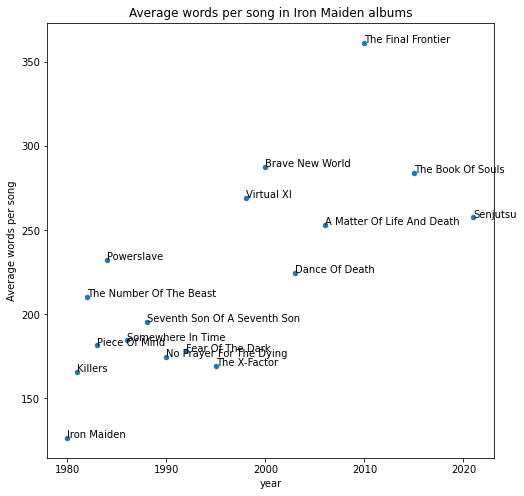

In [9]:
avg_songlen = iron[iron.album != 'No More Lies - Dance Of Death'] \
                  .groupby(['album', 'year']) \
                  .apply(lambda x: x.lyrics.apply(lambda y: len(y.split())).mean()) \
                  .reset_index() \
                  .rename({0:'songlen'}, axis=1) \
                  .sort_values('year')
fig, ax = plt.subplots()
fig.set_figheight(8)
fig.set_figwidth(8)
avg_songlen.plot.scatter('year', 'songlen', ax=ax)
ax.set_ylabel('Average words per song')
plt.title('Average words per song in Iron Maiden albums')
for _, row in avg_songlen.iterrows():
    ax.annotate(row.album, (row.year, row.songlen))
fig.savefig('avg song len by maiden album.png')

In [10]:
iron['lyrics'] = iron.lyrics.apply(
    lambda x: nlp(my_sentencizer([x.split() for x in x.split('\\n')[:-1]]))
)

In [11]:
play_for_blood = nlp("Anybody searching for action. Anything to fill the emptiness inside. Any place that the streets are empty. Any takers wanna pour out their lives. With fire and lightning shooting from my hand. And desolation written across my eyes. My itchy finger on the hairpin trigger. My tempers hot and my patience's taken flight. . Inside the abattoir. The cover charge is somebody's gotta die. Now, I hear you screaming out for mercy. Last man that's standing wins the fight. Too late, I see your end zero in on you. Even mortal enemies, they can't deny. Let me help you up again. The wings of god surround me. I live to play because I know I'll never die. . If I win again, I'm still the champion. And if you win, ha, that's just impossible. I don't play for keeps; I don't play for your soul. I don't play to win; I don't play for it all. I play for blood. . I don't play for keeps, I play for blood. I don't play for your soul, I play for blood. I don't play to win, I play for blood. I don't play for it all, I play for blood. I play for blood")
displacy.render(play_for_blood, style='ent')

In [12]:
dethklok = nlp('''Night sky Bleeds red.
Black birds Bring DETH.
You'll be eaten by the blackness Of your rotting mind that's dying.
You're consumed with sharpened wings That penetrate your frightened lying.''')
# Dethklok, The Dethalbum, Song 6: Go Forth And Die
displacy.render(dethklok, style='ent')

In [13]:
two_mins = iron.lyrics[iron.title == '2 Minutes To Midnight'].iat[0]
displacy.render(two_mins, style='ent')

In [14]:
iron['word_count'] =  iron.lyrics.apply(lambda song: sum(tok.text not in punct for tok in song))

In [15]:
labs = ['death', 'time', 'light']
for lab in labs:
    iron[f'{lab}_count'] = iron.lyrics.apply(lambda song: sum(e.label_ == lab.upper() for e in song.ents))
    iron[f'{lab}_per_word'] = iron[f'{lab}_count'] / iron['word_count']

In [16]:
iron.iloc[[0, 1, -2, -1]]

,album,year,num,title,lyrics,word_count,death_count,death_per_word,time_count,time_per_word,light_count,light_per_word
0,Iron Maiden,1980,1,Prowler,"(Walking, through, the, city, ,, looking, oh, ...",111,0,0.000000,0,0.000000,0,0.000000
1,Iron Maiden,1980,2,Sanctuary,"(Out, of, winter, came, a, warhorse, of, steel...",190,1,0.005263,0,0.000000,1,0.005263
185,Senjutsu,2021,9,The Parchment,"(When, the, moon, will, rise, again, ., Until,...",360,9,0.025000,3,0.008333,9,0.025000
186,Senjutsu,2021,10,Hell On Earth,"(Beginning, of, a, sunrise, bores, a, big, hol...",303,8,0.026403,0,0.000000,4,0.013201


In [17]:
stats_by_album = iron.groupby(['album', 'year']).apply(lambda x: {'death_per_word': x.death_count.sum()/x.word_count.sum(),
                                                     'time_per_word': x.time_count.sum()/x.word_count.sum(),
                                                     'light_per_word': x.light_count.sum()/x.word_count.sum()}) \
                     .reset_index() \
                     .sort_values('year') \
                     .reset_index(drop=True) \
                     .rename({0: 'stats'}, axis=1)
for colname in ['death_per_word', 'time_per_word', 'light_per_word']:
    stats_by_album[colname] = stats_by_album.loc[:, 'stats'].apply(lambda x: x[colname])

stats_by_album.drop('stats', axis=1, inplace=True)

In [18]:
stats_by_album.iloc[[0,1,-2,-1]]

,album,year,death_per_word,time_per_word,light_per_word
0,Iron Maiden,1980,0.011485,0.004102,0.008203
1,Killers,1981,0.021288,0.008188,0.007642
15,The Book Of Souls,2015,0.023634,0.018645,0.018908
16,Senjutsu,2021,0.025936,0.013460,0.014445


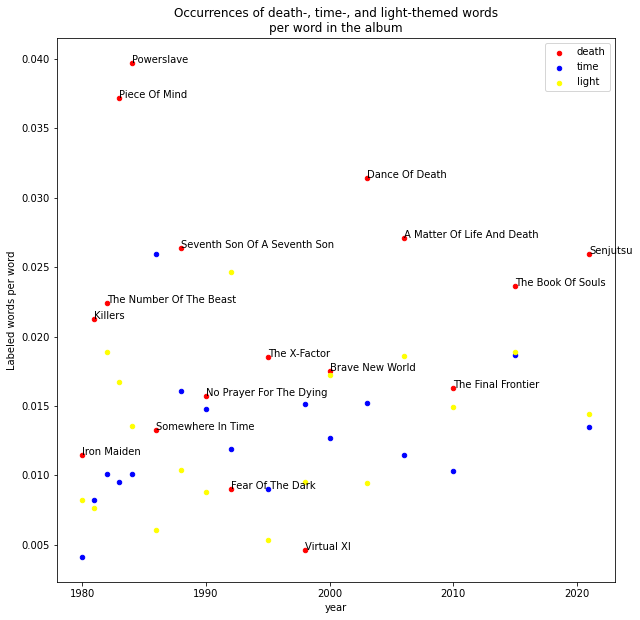

In [19]:
fig, ax = plt.subplots()
fig.set_figheight(10)
fig.set_figwidth(10)
colors = ['red', 'blue', 'yellow']
for lab, color in zip(labs, colors):
    stats_by_album.plot.scatter('year', f'{lab}_per_word', ax=ax, color=color)
for _, row in stats_by_album.iterrows():
    ax.annotate(row.album, (row.year, row.death_per_word))
plt.legend(labs)
plt.ylabel('Labeled words per word')
plt.title('Occurrences of death-, time-, and light-themed words\nper word in the album')
plt.savefig('death_time_light_freq.png')

In [25]:
ghost_nav = iron[iron.title.str.contains('Ghost')].iat[0, 4]
displacy.render(ghost_nav, style='ent')